# Coalescent simulation with msprime

This notebook gives all code needed for the examples in the Statistical Population Genomics chapter dedicated to msprime.

In [36]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import msprime  # >= 1.0
import numpy as np
import scipy
import seaborn as sns
import pandas as pd
import concurrent.futures as cf
import matplotlib.pyplot as plt
from IPython.display import SVG

# Running simulations

# Trees and replication

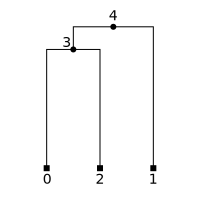

In [43]:
ts = msprime.sim_ancestry(3, ploidy=1)
tree = ts.first()
SVG(tree.draw())

In [44]:
N = 1000
mean_T_mrca = 0
for ts in msprime.sim_ancestry(10, num_replicates=N, ploidy=1):
    tree = ts.first()
    mean_T_mrca += tree.time(tree.root)
mean_T_mrca = mean_T_mrca / N
mean_T_mrca

1.8562060325480039

In [45]:
N = 1000
T_mrca = np.zeros(N)
for j, ts in enumerate(msprime.sim_ancestry(10, num_replicates=N, ploidy=1)):
    tree = ts.first()
    T_mrca[j] = tree.time(tree.root)
np.mean(T_mrca), np.var(T_mrca)

(np.float64(1.7452774355439065), np.float64(1.1464527727599203))

In [46]:
def run_simulation(seed):
    ts = msprime.sim_ancestry(10, random_seed=seed, ploidy=1)
    tree = ts.first()
    return tree.time(tree.root)

N = 1000
seeds = np.random.randint(1, 2**32 - 1, N)

with cf.ProcessPoolExecutor(max_workers=4) as executor:
     futures = [executor.submit(run_simulation, seed) for seed in seeds]
     T_mrca = np.array([f.result() for f in cf.as_completed(futures)])

np.mean(T_mrca)

np.float64(1.850021147866609)

## Population models

In [47]:
def pairwise_T_mrca(population_size):
    N = 10000
    T_mrca = np.zeros(N)
    for j, ts in enumerate(msprime.sim_ancestry(2, population_size=population_size, num_replicates=N, ploidy=1)):
        tree = ts.first()
        T_mrca[j] = tree.time(tree.root)
    return np.mean(T_mrca)

pairwise_T_mrca(0.5), pairwise_T_mrca(10), pairwise_T_mrca(100)

(np.float64(0.49410032757249767),
 np.float64(9.939436524303801),
 np.float64(99.78092484011661))

### Exponentially growing/shrinking populations

In [48]:
def pairwise_T_mrca(growth_rate):
    N = 10000
    T_mrca = np.zeros(N)
    demography = msprime.Demography.isolated_model(initial_size=[0.5],
                                                   growth_rate=[growth_rate])
    replicates = msprime.sim_ancestry(
        samples=2,
        demography=demography,
        num_replicates=N,
        ploidy=1,
        random_seed=100)

    for j, ts in enumerate(replicates):
        tree = ts.first()
        T_mrca[j] = tree.time(tree.root)
    return np.mean(T_mrca)

pairwise_T_mrca(0.05), pairwise_T_mrca(0), pairwise_T_mrca(-0.05)

(np.float64(0.4775720920641944),
 np.float64(0.4889637700421355),
 np.float64(0.5015256860964078))

## Mutations

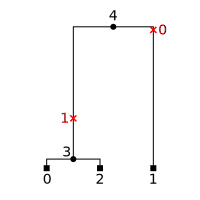

In [49]:
ts = msprime.sim_ancestry(3, ploidy=1, random_seed=7) #sequence_length=2 to get similar results, or change to non discrete genome
ts = msprime.sim_mutations(ts, rate=1, random_seed=7, discrete_genome=False)
tree = ts.first()
SVG(tree.draw())

In [50]:
ts.genotype_matrix()

array([[0, 1, 0],
       [1, 0, 1]], dtype=int32)

In [51]:
N = 10000
theta = 5
S = np.zeros(N)
replicates = msprime.sim_ancestry(2, population_size=0.5, num_replicates=N, ploidy=1, discrete_genome=False)
for j, ts in enumerate(replicates):
    ts = msprime.sim_mutations(ts, rate=theta, discrete_genome=False)
    S[j] = ts.num_sites  # Number of segregrating sites.
np.mean(S)

np.float64(4.9882)

## Population structure

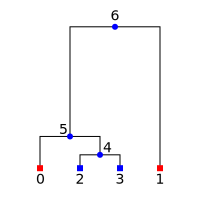

In [52]:

demography =  msprime.Demography.isolated_model([1, 1])
demography.set_migration_rate(source=0, dest=1, rate=0.1)

ts  = msprime.sim_ancestry(
    samples={0:2, 1:2}, ploidy=1,
    random_seed=2, demography=demography)
tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours))

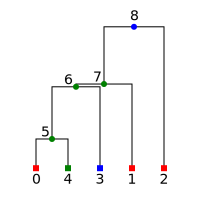

In [53]:
demography =  msprime.Demography.island_model([1, 1, 1], migration_rate=1)

ts  = msprime.sim_ancestry(
    samples={0:3, 1:1, 2:1},
    demography=demography,
    record_migrations=True,
    ploidy=1,
    random_seed=101)
tree = ts.first()
colour_map = {0:"red", 1:"blue", 2: "green"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours))

Text(0, 0.5, 'Number of migrations')

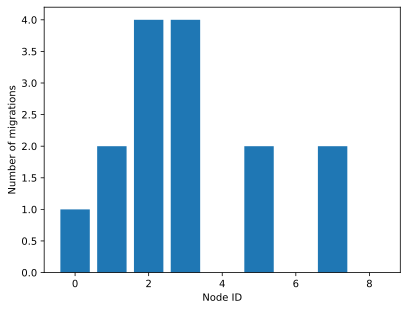

In [54]:
node_count = np.zeros(ts.num_nodes)
for migration in ts.migrations():
    node_count[migration.node] += 1
plt.bar(np.arange(ts.num_nodes), node_count)
plt.xlabel("Node ID")
plt.ylabel("Number of migrations")

## Demes

<Axes: ylabel='time ago (generations)'>

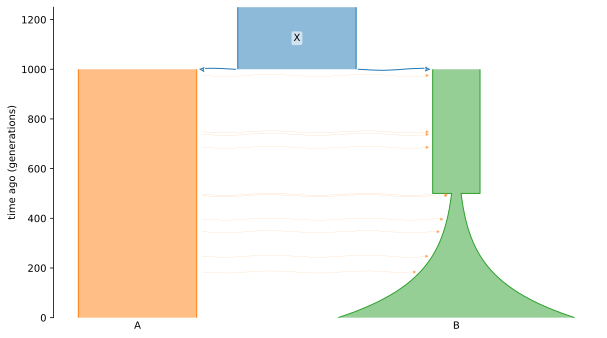

In [ ]:
import demes
import demesdraw

graph = demes.load("demes_example_01.yaml")
demesdraw.tubes(graph)

In [43]:
demography = msprime.Demography.from_demes(graph)
ts = msprime.sim_ancestry({"A":2, "B":3}, demography=demography, random_seed=1234)


## Demographic events


### Migration rate change

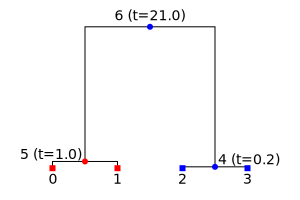

In [55]:
demography = msprime.Demography.isolated_model([1, 1])

demography.add_migration_rate_change(time=20, rate=1, source=0, dest=1)
ts  = msprime.sim_ancestry(
    samples={0:2, 1:2},
    demography=demography,
    ploidy=1,
    random_seed=2)

tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
node_labels = {
    u: (str(u) if tree.is_sample(u) else "{} (t={:.1f})".format(u, tree.time(u)))
    for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours, node_labels=node_labels, width=300))

### Mass migration

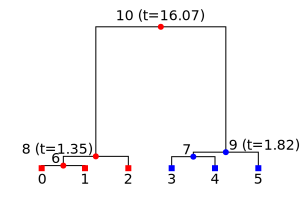

In [56]:
demography = msprime.Demography.isolated_model([1, 1])
demography.add_mass_migration(time=15, source=1, dest=0, proportion=1)

ts  = msprime.sim_ancestry(
    samples={0:3, 1:3},
    demography=demography,
    ploidy=1,
    random_seed=20)
tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
node_labels = {
    u: (str(u) if u < 8 else "{} (t={:.2f})".format(u, tree.time(u)))
    for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours, node_labels=node_labels, width=300))


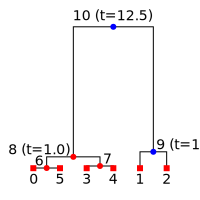

In [57]:
demography = msprime.Demography.isolated_model([1, 1])

demography.add_mass_migration(time=0.5, source=0, dest=1, proportion=0.5)
demography.add_migration_rate_change(time=1.1, rate=0.1)

ts  = msprime.sim_ancestry(
    samples={0:6, 1:0},
    demography=demography,
    ploidy=1,
    random_seed=5)

tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
node_labels = {
    u: (str(u) if u < 8 else "{} (t={:.1f})".format(u, tree.time(u)))
    for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours, node_labels=node_labels))

### Population parameter change

In [58]:
N1 = 20000  # Population size at present
N2 = 2000   # Population size at start (forwards in time) of exponential growth.
T1 = 100    # End of exponential growth period (forwards in time)
T2 = 750    # Start of exponential growth period (forwards in time)
# Calculate growth rate; solve N2 = N1 * exp(-alpha * (T2 - T1))
growth_rate = -np.log(N2 / N1) / (T2 - T1)
demography = msprime.Demography.isolated_model([N1])
demography.add_population_parameters_change(time=T1, growth_rate=growth_rate)
demography.add_population_parameters_change(time=T2, growth_rate=0)

dp = demography.debug()
dp.print_history()

DemographyDebugger
╠════════════════════════════════╗
║ Epoch[0]: [0, 100) generations ║
╠════════════════════════════════╝
╟    Populations (total=1 active=1)
║    ┌───────────────────────────────────────────┐
║    │       │     start│       end│growth_rate  │
║    ├───────────────────────────────────────────┤
║    │  pop_0│   20000.0│   20000.0│ 0           │
║    └───────────────────────────────────────────┘
╟    Events @ generation 100
║    ┌────────────────────────────────────────────────────────────────────────────┐
║    │  time│type        │parameters              │effect                         │
║    ├────────────────────────────────────────────────────────────────────────────┤
║    │   100│Population  │population=-1, growth_  │growth_rate → 0.00354 for all  │
║    │      │parameter   │rate=0.003542438604606  │populations                    │
║    │      │change      │2238                    │                               │
║    └──────────────────────────────────────────────

## Ancient samples

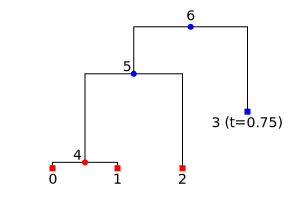

In [59]:

demography = msprime.Demography.island_model(initial_size=[1, 1], migration_rate=1)

ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(1, population=0, time=0),
        msprime.SampleSet(1, population=0, time=0),
        msprime.SampleSet(1, population=0, time=0),
        msprime.SampleSet(1, population=1, time=0.75), # Ancient sample in deme 1
    ],
    demography=demography,
    ploidy=1,
    random_seed=22)
tree = ts.first()
colour_map = {0:"red", 1:"blue"}
node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
node_labels = {
    u: (str(u) if u != 3 else "{} (t={:.2f})".format(u, tree.time(u)))
    for u in tree.nodes()}
SVG(tree.draw(node_colours=node_colours, node_labels=node_labels, width=300))


## Recombination

In [60]:
ts = msprime.sim_ancestry(10, population_size=1e4, sequence_length=1e5, recombination_rate=1e-8, random_seed=3)
ts.num_trees

135

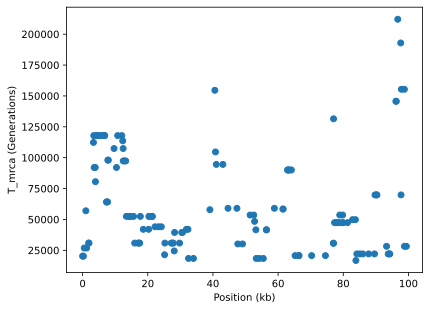

In [61]:
tmrca = np.zeros(ts.num_trees)
breakpoints = np.zeros(ts.num_trees)
for tree in ts.trees():
    tmrca[tree.index] = tree.time(tree.root)
    breakpoints[tree.index] = tree.interval[0]
plt.ylabel("T_mrca (Generations)")
plt.xlabel("Position (kb)")
plt.plot(breakpoints / 1000, tmrca, "o");

In [62]:
# Read in the recombination map and run the simulation.
infile = "genetic_map_GRCh37_chr22.txt"
recomb_map = msprime.RateMap.read_hapmap(infile)
ts = msprime.sim_ancestry(
    samples=100,
    population_size=10**4,
    recombination_rate=recomb_map,
    ploidy=1,
    random_seed=1)

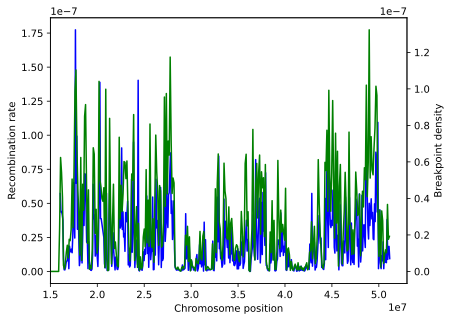

In [63]:
# Now plot the density of breakpoints along the chromosome
breakpoints = np.array(list(ts.breakpoints()))
# Now we get the positions and rates from the recombination
# map and plot these using 500 bins.
positions = np.array(recomb_map.right[1:])
rates = np.array(recomb_map.rate[1:])

num_bins = 500
v, bin_edges, _ = scipy.stats.binned_statistic(
    positions, rates, bins=num_bins)

x = bin_edges[:-1][np.logical_not(np.isnan(v))]
y = v[np.logical_not(np.isnan(v))]
fig, ax1 = plt.subplots()
ax1.plot(x, y, color="blue")
ax1.set_ylabel("Recombination rate")
ax1.set_xlabel("Chromosome position")
ax2 = ax1.twinx()
v, bin_edges = np.histogram(breakpoints, num_bins, density=True)
ax2.plot(bin_edges[:-1], v, color="green")
ax2.set_ylabel("Breakpoint density")
ax2.set_xlim(1.5e7, 5.3e7);

In [64]:
recomb_map = msprime.RateMap.uniform(sequence_length=10, rate=1)
ts = msprime.sim_ancestry(2, recombination_rate=recomb_map)
list(ts.breakpoints())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

# Processing results

In [65]:
%%time

demography = msprime.Demography.isolated_model([2*(10**4)]*2)


demography.add_mass_migration(time=50000, source=1, dest=0, proportion=1.0)

ts = msprime.sim_ancestry(
    samples={0: 10**5, 1: 10**5},
    demography=demography, recombination_rate=1e-8,
    sequence_length=10*10**6, random_seed=3,
    ploidy=1)

ts = msprime.sim_mutations(ts, rate=1e-8, random_seed=7, discrete_genome=False)

CPU times: user 9.46 s, sys: 53.9 ms, total: 9.51 s
Wall time: 9.51 s


In [66]:
ts.num_trees, ts.num_sites


(93598, 102783)

## Computing MRCAs

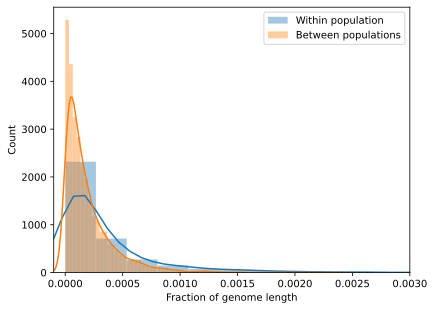

In [67]:
def ibd_segments(ts, a, b):
    trees_iter = ts.trees()
    tree = next(trees_iter)
    last_mrca = tree.mrca(a, b)
    last_left = 0
    segment_lengths = []
    for tree in trees_iter:
        mrca = tree.mrca(a, b)
        if mrca != last_mrca:
            left = tree.interval[0]
            segment_lengths.append(left - last_left)
            last_mrca = mrca
            last_left = left
    segment_lengths.append(ts.sequence_length - last_left)
    return np.array(segment_lengths) / ts.sequence_length

sns.histplot(ibd_segments(ts, 0, 1), label="Within population", kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4), bins=70)
sns.histplot(ibd_segments(ts, 0, 10**5), label="Between populations", kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4), bins=70)
plt.xlim(-0.0001, 0.003)
plt.legend()
plt.ylabel("Count")
plt.xlabel("Fraction of genome length");

## Sample counts

In [68]:
N = ts.num_samples
threshold = 0.01
num_rare_derived = 0
for tree in ts.trees():
    for site in tree.sites():
        assert len(site.mutations) == 1
        mutation = site.mutations[0]
        if tree.num_samples(mutation.node) / N < threshold:
            num_rare_derived += 1
num_rare_derived, num_rare_derived / ts.num_sites

(65292, 0.635241236391232)

In [69]:
def num_private_sites(pop_id):
    pop_samples = ts.samples(pop_id)
    num_private = 0
    for tree in ts.trees(tracked_samples=pop_samples):
        for site in tree.sites():
            assert len(site.mutations) == 1
            mutation = site.mutations[0]
            total = tree.num_samples(mutation.node)
            within_pop = tree.num_tracked_samples(mutation.node)
            if total == within_pop:
                num_private += 1
    return num_private

private_0 = num_private_sites(0)
private_1 = num_private_sites(1)
ts.num_sites, private_0 + private_1, private_0, private_1

(102783, 102117, 50850, 51267)

## Obtaining subsets

In [70]:
samples = [1, 3, 5, 7]
ts_subset = ts.simplify(samples)
ts_subset.num_sites, ts_subset.num_trees, ts.num_sites, ts.num_trees

(11925, 5323, 102783, 93598)

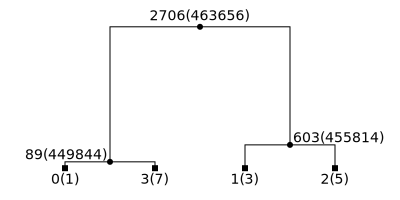

In [71]:
ts_subset, node_map = ts.simplify(samples, map_nodes=True)
tree = ts_subset.first()
node_labels = {
    node_map[j]: "{}({})".format(node_map[j], str(j)) for j in range(ts.num_nodes)}
SVG(tree.draw(node_labels=node_labels, width=400))

## Processing variants

In [72]:
%%time
threshold = 0.1
num_rare = 0
for variant in ts.variants():
    # Will work for any biallelic sites; back/recurrent mutations are fine.
    assert len(variant.alleles) == 2
    if np.sum(variant.genotypes) / ts.num_samples < threshold:
        num_rare += 1
print(num_rare)

83757
CPU times: user 22.4 s, sys: 0 ns, total: 22.4 s
Wall time: 22.4 s


In [73]:
%%time
threshold = 0.1
num_rare = 0
for tree in ts.trees():
    for site in tree.sites():
        # Only works for simple infinites sites mutations.
        assert len(site.mutations) == 1
        mutation = site.mutations[0]
        if tree.num_samples(mutation.node) / ts.num_samples < threshold:
            num_rare += 1
print(num_rare)

83757
CPU times: user 593 ms, sys: 0 ns, total: 593 ms
Wall time: 592 ms


## Incremental calculations

In [74]:
def get_total_branch_length(ts):
    current = 0
    total_branch_length = np.zeros(ts.num_trees)
    for index, (_, edges_out, edges_in) in enumerate(ts.edge_diffs()):
        for edge in edges_out:
            current -= ts.node(edge.parent).time - ts.node(edge.child).time
        for edge in edges_in:
            current += ts.node(edge.parent).time - ts.node(edge.child).time
        total_branch_length[index] = current
    return total_branch_length

In [75]:
%%time
tbl = get_total_branch_length(ts)

CPU times: user 4.44 s, sys: 35.3 ms, total: 4.48 s
Wall time: 4.48 s


In [76]:
#%%time
# Took > 20 minutes before getting bored.
# tbl2 = np.array([tree.total_branch_length for tree in ts.trees()])

# Validating analytical predictions

## Total branch length and segregating sites

In [77]:
ns = np.array([5, 10, 15, 20, 25, 30])
num_reps = 10000
n_col = np.zeros(ns.shape[0] * num_reps)
T_total_col = np.zeros(ns.shape[0] * num_reps)
row = 0
for n in ns:
    for ts in msprime.sim_ancestry(n, population_size=1, num_replicates=num_reps, ploidy=1):

        tree = ts.first()
        n_col[row] = n
        T_total_col[row] = tree.total_branch_length
        row += 1
df = pd.DataFrame({"n": n_col, "T_total": T_total_col})

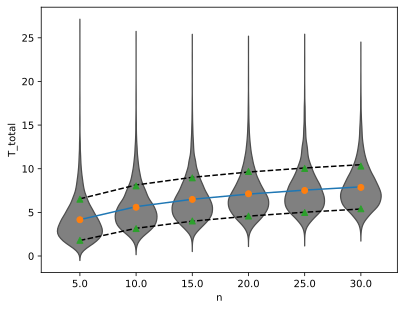

In [78]:
def T_total_mean(n):
    return 2 * np.sum(1 / np.arange(1, n))

def T_total_var(n):
    return 4 * np.sum(1 / np.arange(1, n)**2)

mean_T = np.array([T_total_mean(n) for n in ns])
stddev_T = np.sqrt(np.array([T_total_var(n) for n in ns]))
ax = sns.violinplot(x="n", y="T_total", data=df, color="grey", inner=None)
ax.plot(mean_T, "-");
ax.plot(mean_T - stddev_T, "--", color="black");
ax.plot(mean_T + stddev_T, "--", color="black");
group = df.groupby("n")
mean_sim = group.mean()
stddev_sim = np.sqrt(group.var())
x = np.arange(ns.shape[0])
ax.plot(x, mean_sim, "o")
line, = ax.plot(x, mean_sim - stddev_sim, "^")
ax.plot(x, mean_sim + stddev_sim, "^", color=line.get_color());

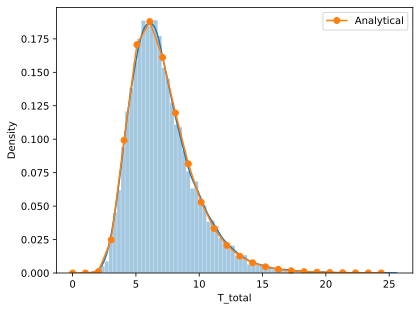

In [79]:
def T_total_density(n, t):
    e_t2 = np.exp(-t / 2)
    return 0.5 * (n - 1) * e_t2 * (1 - e_t2)**(n - 2)

n = 20
T_total_20 = T_total_col[n_col == n]
ts = np.linspace(0, np.max(T_total_20), 25)
t_densities = np.array([T_total_density(n, t) for t in ts])
sns.histplot(T_total_20, kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4), bins=70)
plt.plot(ts, t_densities, marker="o", label="Analytical", color="Tab:orange")
plt.xlabel("T_total")
plt.legend();

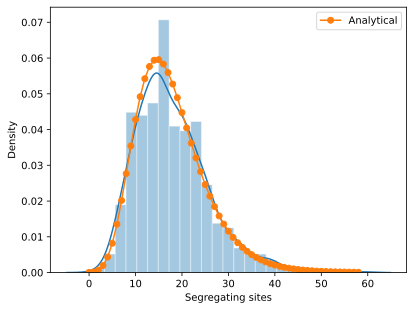

In [80]:
def S_dist(n, theta, k):
    S = 0
    for i in range(2, n + 1):
        S += ((-1)**i * scipy.special.binom(n - 1, i - 1)
              * (i - 1) / (theta + i - 1) * (theta / (theta + i - 1))**k)
    return S

n = 20
theta = 5
num_replicates = 1000
simulation = np.zeros(num_replicates)
replicates = msprime.simulate(
    n, Ne=0.5, mutation_rate=theta / 2, num_replicates=num_replicates)
for j, ts in enumerate(replicates):
    simulation[j] = ts.num_sites  # number of seg. sites
ks = np.arange(np.max(simulation))
analytical = np.array([S_dist(n, theta, k) for k in ks])
sns.histplot(simulation, kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4), bins=25)
plt.plot(ks, analytical, marker='o', label="Analytical", color="Tab:orange")
plt.xlabel("Segregating sites")
plt.legend();

## Recombination

In [81]:
theta = 2
num_replicates = 10000
rhos = np.arange(1, 10)
N = rhos.shape[0] * num_replicates
rho_col = np.zeros(N)
s_col = np.zeros(N)
row = 0
for rho in rhos:
    replicates = msprime.sim_ancestry(1, num_replicates=num_replicates,
                                      recombination_rate=rho/2, population_size=0.5,
                                      discrete_genome=False, sequence_length=1
                                      )

    for ts in replicates:
        ts = msprime.sim_mutations(ts, rate=theta/2, discrete_genome=False)

        rho_col[row] = rho
        s_col[row] = ts.num_sites
        row += 1
df = pd.DataFrame({"rho": rho_col, "s": s_col})

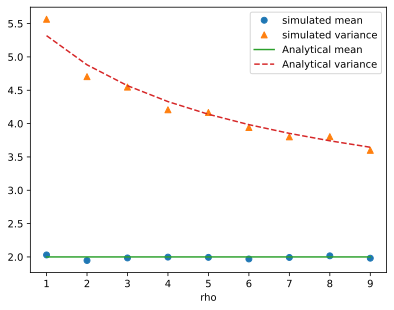

In [82]:
def pairwise_S_mean(theta):
    return theta

def f2(rho):
    return (rho + 18) / (rho**2 + 13 * rho + 18)

def pairwise_S_var(theta, rho):
    integral = scipy.integrate.quad(lambda x: (rho - x) * f2(x), 0, rho)
    return theta + 2 * theta**2 * integral[0] / rho**2


group = df.groupby("rho")
plt.plot(group.mean(), "o", label="simulated mean")
plt.plot(group.var(), "^", label="simulated variance")
plt.plot(rhos, [pairwise_S_mean(theta) for rho in rhos], "-", label="Analytical mean")
plt.plot(rhos, [pairwise_S_var(theta, rho) for rho in rhos], "--", label="Analytical variance")
plt.xlabel("rho")
plt.legend();

# Example inference scheme

In [96]:
nsamp = 2
theta = 2
true_m = 0.3
num_loci = 200

def run_sims(m, num_loci=1, theta=0):
    demography = msprime.Demography.island_model([1, 1], migration_rate=m)
    replicates = msprime.sim_ancestry({0: nsamp, 1:nsamp},
                                      demography=demography,
                                      num_replicates=num_loci, ploidy=1,
                                      discrete_genome=False, sequence_length=1)
    for ts in replicates:
        yield msprime.sim_mutations(ts, rate=theta, discrete_genome=False)

def get_joint_site_frequency_spectra(reps):
    data = np.zeros((num_loci, nsamp + 1, nsamp + 1))
    for rep_index, ts in enumerate(reps):
        data[rep_index] = ts.allele_frequency_spectrum([[0, 1], [2,3]], polarised=True)

    return data

truth = get_joint_site_frequency_spectra(
    run_sims(true_m, num_loci=num_loci, theta=2))

In [97]:
print("jSFS counts, first locus =")
print(truth[0])

jSFS counts, first locus =
[[ 0.  0.  8.]
 [ 4.  0.  0.]
 [12.  0.  0.]]


In [98]:
truth_mean = np.mean(truth, axis=0)
truth_mean /= np.sum(truth_mean)
print("mean jSFS =")
print(truth_mean)

mean jSFS =
[[0.         0.19612591 0.20169492]
 [0.23196126 0.02881356 0.07094431]
 [0.20460048 0.06585956 0.        ]]


In [99]:
import tskit

num_reps = 100
num_prior_draws = 10000
prior_m = np.random.exponential(0.1, num_prior_draws)

def approx_jSFS(m):
    reps = run_sims(m, num_loci=num_reps)
    B = np.zeros((num_reps, nsamp + 1, nsamp + 1))
    for rep_index, ts in enumerate(reps):
        samp1 = ts.samples(population_id=0)
        for tree in ts.trees(tracked_samples=samp1):
            # Note that this will be inefficient if we have lots of trees. Should
            # use an incremental update strategy using edge_diffs in this case.
            for u in tree.nodes():
                nleaves1 = tree.num_tracked_samples(u)
                nleaves2 = tree.num_samples(u) - nleaves1
                if tree.parent(u) != tskit.NULL:
                    B[rep_index, nleaves1, nleaves2] += tree.branch_length(u)
    data = np.mean(B, axis=0)
    return data / np.sum(data)


with cf.ProcessPoolExecutor(max_workers=4) as executor:
     futures = [executor.submit(approx_jSFS, m) for m in seeds]
     T_mrca = np.array([f.result() for f in cf.as_completed(futures)])

print(prior_jSFS[0])

[[0.00000000e+00 4.48289074e-02 4.51808257e-01]
 [1.75836858e-02 2.70274460e-04 3.53068275e-03]
 [4.52414225e-01 2.95639680e-02 0.00000000e+00]]


In [87]:
distances = np.zeros(num_prior_draws)
for j in range(num_prior_draws):
    distances[j] = np.sqrt(np.sum((prior_jSFS[j] - truth_mean)**2))

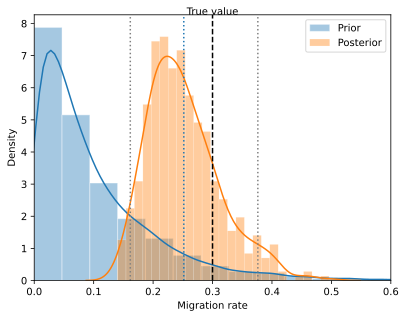

In [88]:
cutoff = np.percentile(distances, 5)
keep = np.where(distances < cutoff)
post_m = prior_m[keep]
mean_m = np.mean(post_m)
ci_m = np.percentile(post_m, 2.5), np.percentile(post_m, 95.75)
sns.histplot(prior_m, label="Prior", kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4), bins=25)
sns.histplot(post_m, label="Posterior", kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4), bins=25)
plt.xlabel("Migration rate");
plt.axvline(x=true_m, ls="--", color="black")
plt.axvline(x=mean_m, ls=":")
plt.axvline(x=ci_m[0], ls=":", color="grey")
plt.axvline(x=ci_m[1], ls=":", color="grey")
plt.text(true_m, plt.ylim()[1], "True value", horizontalalignment="center")
plt.xlim(0, 0.6)
plt.legend();

In [89]:
print([mean_m, ci_m])

[np.float64(0.251637260585496), (np.float64(0.16163120508461157), np.float64(0.376232937821976))]


## Cross-validation using pseudoobserved data sets

In [90]:
num_loci = 200
num_pseudo_obs = 100
data_pseudo_obs = np.zeros((num_pseudo_obs, nsamp+1, nsamp+1))
for j in range(num_pseudo_obs):
    data = get_joint_site_frequency_spectra(
        run_sims(true_m, num_loci=num_loci, theta=2))
    data_mean = np.mean(data, axis=0)
    data_pseudo_obs[j] = data_mean / np.sum(data_mean)

We record the mean posterior estimate of $m$ for each PODS. The standard deviation (SD) of $m$ estimates across PODS is 0.04. We can use this to obtain an approximate estimate of the 95% posterior credibility interval (+/- 2SD), which is slightly narrower than the 95% posterior credibility interval estimated from the posterior distribution of a single PODS above.

In [91]:
mean_ests = np.zeros(num_pseudo_obs)
for k in range(num_pseudo_obs):
    distances = np.zeros(num_prior_draws)
    for j in range(num_prior_draws):
        distances[j] = np.sqrt(np.sum((data_pseudo_obs[k] - prior_jSFS[j])**2))
    keep = np.where(distances < cutoff)
    mean_ests[k] = np.mean(prior_m[keep])

[np.float64(0.4987284377665812), [np.float64(0.3017717072664814), np.float64(0.695685168266681)]]


Text(0.5, 104.7375, 'True value')

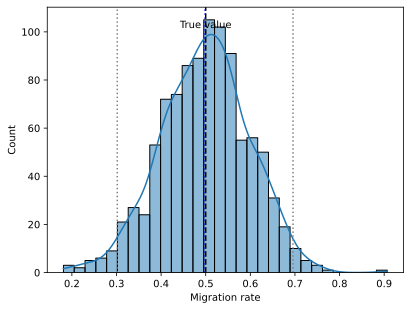

In [92]:
mean_ests = np.random.normal(0.5, 0.1, 1000)  # Simulated example
true_m = 0.5

meanmPODS = np.mean(mean_ests)
SDmPODS = np.std(mean_ests)

print([meanmPODS, [meanmPODS - 2 * SDmPODS, meanmPODS + 2 * SDmPODS]])

# Updated plot using histplot with KDE
sns.histplot(mean_ests, kde=True, bins=30)

plt.xlabel("Migration rate")

# Vertical lines for true value, mean, and confidence range
plt.axvline(x=true_m, ls="--", color="black", label="True Value")
plt.axvline(x=meanmPODS, ls=":", color="blue", label="Mean Estimate")
plt.axvline(x=meanmPODS - 2 * SDmPODS, ls=":", color="grey")
plt.axvline(x=meanmPODS + 2 * SDmPODS, ls=":", color="grey")

# Text annotation for the true value
plt.text(true_m, plt.ylim()[1] * 0.95, "True value",
         horizontalalignment="center", verticalalignment="top")

Although the true value of of $m=0.3$ is contained within the 95 % credible interval, the posterior distribution is clearly downwardly biased. This bias is expected given that our prior is biased towards low $m$. We can check the effect the acceptance threshold has on the inference, by computing the root-mean-square error (RMSE) for a range of thresholds:

In [93]:
cutoffs = np.array([0.675,1.25,2.5,5,10,20])
len_c = len(cutoffs)
mean_ests = np.zeros((len_c,num_pseudo_obs))
for i in range(len_c):
    for k in range(num_pseudo_obs):
        distances = np.zeros(num_prior_draws)
        for j in range(num_prior_draws):
            distances[j] = np.sqrt(np.sum((data_pseudo_obs[k] - prior_jSFS[j])**2))
        cutoff = np.percentile(distances, cutoffs[i])
        keep = np.where(distances < cutoff)
        mean_ests[i][k] = np.mean(prior_m[keep])

In [94]:
mean_m = np.mean(mean_ests, axis=1)
mean_square_err = np.zeros((len_c,num_pseudo_obs))
for i in range(len_c):
    for k in range(num_pseudo_obs):
        mean_square_err[i][k] = (mean_ests[i][k] - true_m)**2
mean_square_err_fin =[np.sqrt(np.sum(mean_square_err[i])) for i in range(len_c)]

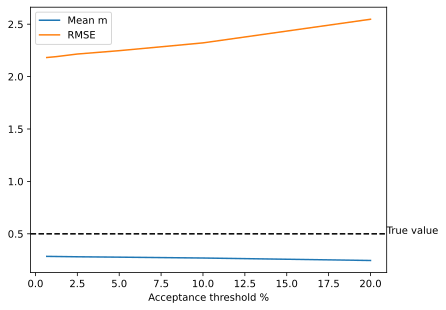

In [95]:
plt.plot(cutoffs, mean_m, label="Mean m");
plt.plot(cutoffs, mean_square_err_fin, label="RMSE")
plt.xlabel("Acceptance threshold %")
plt.axhline(y=true_m, ls="--", color="black")
plt.text(plt.xlim()[1], true_m, "True value")
plt.legend();

Ploting the mean and the RMSE against the acceptance threshold shows that both the downward bias in $m$ estimates and the associated RMSE increase with larger acceptance tresholds as expected. However, sampling only a small farction of simulations generated under the prior is computationally inefficient and more efficient sampling strategies for ABC inference have been developed (Beaumont 2002). While this toy example illustrates the principle of ABC, in practice we are generally interested in fitting parameter-rich models and it would be straightforward to implement ABC inference for complex model of population structure and demography in msprime.